# This Exploration Notebook evaluates the udacity dataset.

# Credits

Credits shall go to these papers and blog post which inspired me for this project:

* http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
* https://medium.com/@subodh.malgonde/teaching-a-car-to-mimic-your-driving-behaviour-c1f0ae543686#.r9rvmm3so
* https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.itxajj34m
* https://carnd-forums.udacity.com/cq/viewquestion.action?id=26214464&questionTitle=behavioral-cloning-cheatsheet
* https://carnd-udacity.atlassian.net/wiki/pages/viewpage.action?pageId=30441475

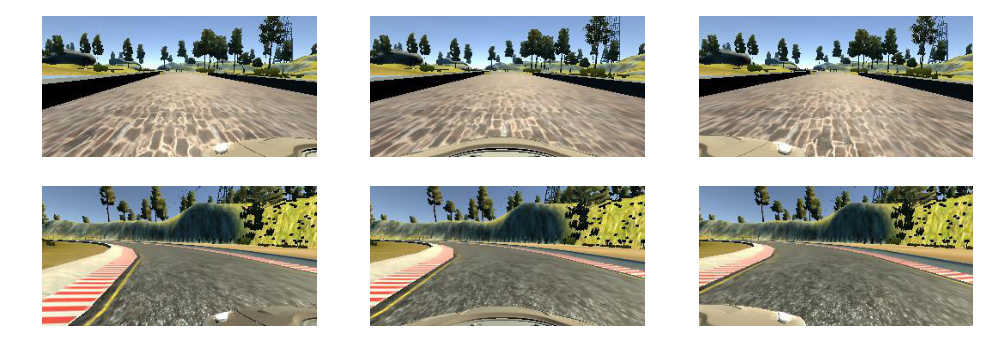

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

kExplorationDir = 'exploration/'
kFolderName = 'C:/_HAF/sdc/behavioral-cloning/udacity_data'
kNumberOfImages = 6

images = np.ones((kNumberOfImages, 160, 320, 3), dtype=np.uint8)

plt.rcParams['figure.figsize'] = (12, 4)
for i in range(kNumberOfImages):
    image = mpimg.imread(kExplorationDir + "raw%d.jpg" % i)
    images[i] = image
    
    plt.subplot(2, 3, i+1)
    plt.imshow(image, aspect='auto')
    plt.axis('off')

# Cropping Required

1. The actual visible road is superimposed by the vehicle's body
2. The image contains a lot of sky which is not helpful to train the network

Hence we can crop the image at the top and bottom

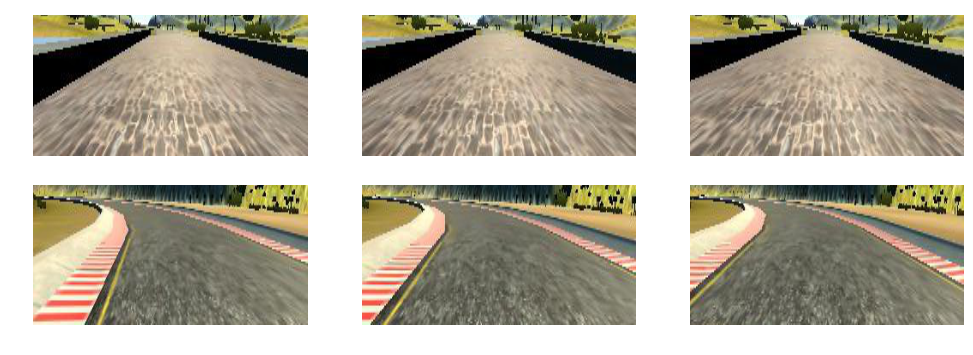

In [2]:
kInputCols = 320
kInputRows = 160
kCropTop = 55
kCropBottom = kInputRows - 25

for i in range(kNumberOfImages):
    image = images[i]
    cropped_image = image[kCropTop:kCropBottom, :, :]
    
    plt.subplot(2, 3, i+1)
    plt.imshow(cropped_image, aspect='auto')
    plt.axis('off')

# Exploring Input Data from driving_log.csv

The CSV file holds the references to the images and links those to the steering angle and even driving data such as speed and throttle.

In [3]:
import pandas as pd

data_frame = pd.read_csv('udacity_data/driving_log.csv')
data_frame.describe(include='all')

,center,left,right,steering,throttle,brake,speed
count,8036,8036,8036,8036.000000,8036.000000,8036.000000,8036.000000
unique,8036,8036,8036,NaN,NaN,NaN,NaN
top,IMG/center_2016_12_01_13_37_38_030.jpg,IMG/left_2016_12_01_13_46_17_071.jpg,IMG/right_2016_12_01_13_46_04_581.jpg,NaN,NaN,NaN,NaN
freq,1,1,1,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.004070,0.869660,0.001970,28.169839
std,NaN,NaN,NaN,0.128840,0.301326,0.036565,6.149327
min,NaN,NaN,NaN,-0.942695,0.000000,0.000000,0.502490
25%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.183093
50%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.186400
75%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.186640


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000089535C0>]], dtype=object)

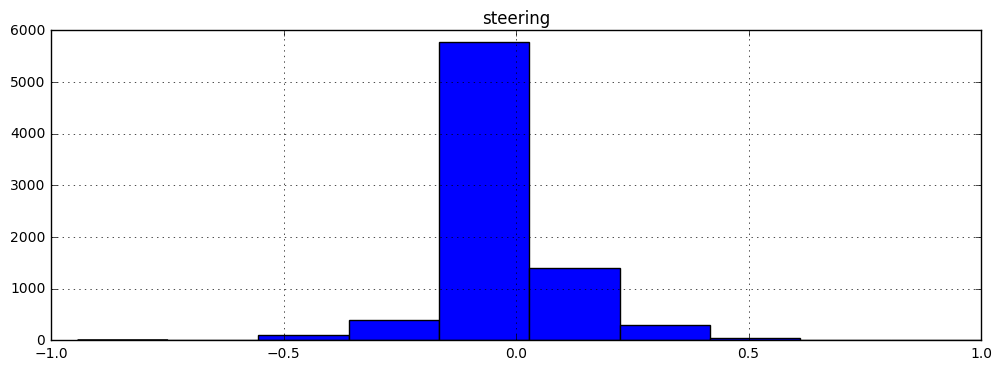

In [4]:
data_frame.hist(column='steering')

# Unbalanced Data

1. We can observe that most of the time the steering angle is close to zero
2. Strong steering angles are very rare
3. There is a bias towards steering angles which are positive

Hence the data set is very unbalanced towards small steering angles which can be problematic in strong curves.
Also the bias of positive angles can be problematic.

# Countermeasure for positive steering angle bias

The images can be flipped horizontally (and invert the corresponding steering angle), so that we can reduce the bias for turing left.

# Countermeasure for small steering angle bias

Possible solution orr #2 is to increase the number if images and steering angles where we detect a high degree of curvature, based on the actual input steering angle. By duplicating those detected images we get a slighty more balanced dataset. 

In [5]:
kSteeringThresholds = [0.20, 0.40, 0.60]
kAddingFactor = 2

def add_curvy_images(input_data, thresholds):    
    abs_steering = np.abs(input_data['steering'])

    for threshold in thresholds:
        is_curve = abs_steering > threshold
        curve_rows = input_data[is_curve]
            
        for i in range(kAddingFactor):
            input_data = input_data.append(curve_rows, ignore_index=False)
            
    return input_data.reindex()
    
data_frame_added = add_curvy_images(data_frame, kSteeringThresholds)
data_frame_added.describe(include='all')

C:\Conda\envs\python3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,center,left,right,steering,throttle,brake,speed
count,11020,11020,11020,11020.000000,11020.000000,11020.000000,11020.000000
unique,8036,8036,8036,NaN,NaN,NaN,NaN
top,IMG/center_2016_12_01_13_34_38_562.jpg,IMG/left_2016_12_01_13_38_59_461.jpg,IMG/right_2016_12_01_13_39_27_520.jpg,NaN,NaN,NaN,NaN
freq,27,27,27,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,-0.012381,0.860636,0.001908,28.089328
std,NaN,NaN,NaN,0.267147,0.304968,0.036406,6.082720
min,NaN,NaN,NaN,-0.942695,0.000000,0.000000,0.502490
25%,NaN,NaN,NaN,-0.078746,0.985533,0.000000,30.164070
50%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.185365
75%,NaN,NaN,NaN,0.071328,0.985533,0.000000,30.186620


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000AE77F98>]], dtype=object)

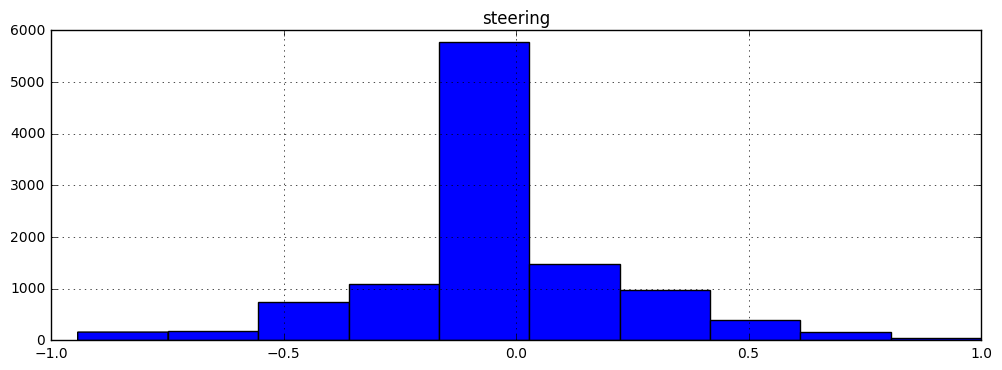

In [6]:
data_frame_added.hist(column='steering')

# Using multiple Cameras

The udacity dataset provides multiple camera images, left, center and right.

Using TensorFlow backend.


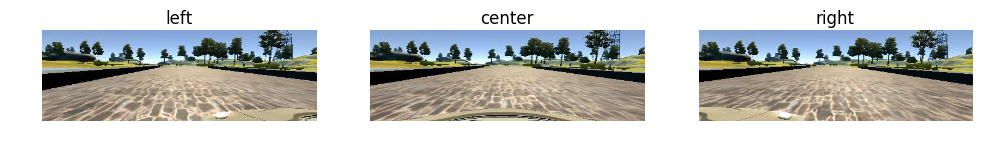

In [7]:
from keras.preprocessing.image import img_to_array, load_img

for i, camera in enumerate(['left', 'center', 'right']):
    image = load_img(kFolderName + '/' + data_frame.iloc[0][camera].strip())
    image = img_to_array(image).astype(np.uint8)
    
    plt.subplot(3, 3, i+1)
    plt.imshow(image, aspect='auto')
    plt.axis('off')
    plt.title(camera)

# Recovery

We can incorporate the left and right camera images to simulate recovery, by adding or subtracting an artificial steering angle to the center steering value according to the direction.

# Augmentation

## Use left & right camera images to simulate recovery
Using left and right camera images to simulate the effect of car wandering off to the side, and recovering. 
We will add a small angle 0.25 to the left camera and subtract a small angle of 0.25 from the right camera. 
The main idea being the left camera has to move right to get to center, and right camera has to move left.

## Flip the images horizontally
Since the dataset has a lot more images with the car turning left than right(because there are more left turns in the track), you can flip the image horizontally to simulate turing right and also reverse the corressponding steering angle.

## Brightness Adjustment
In this you adjust the brightness of the image to simulate driving in different lighting conditions

## Add Random Shadows
By adding random shadows we can increase the number of augmented images to as many as we want. The idea behind the shadowing is that the network will be trained to detect the actual important edges of the street and no edges introduced by bad lightning conditons.

In [8]:
import cv2

kMinBrightness = 0.25
kSteeringAdjustments = 0.25

def alter_image_brightness(image):
    # Convert to HSV space so that its easy to adjust brightness
    altered_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Randomly generate the brightness reduction factor
    # Add a constant so that it prevents the image from being completely dark
    random_brightness = kMinBrightness + np.random.uniform()

    # Apply the brightness reduction to the V channel
    altered_image[:,:,2] = altered_image[:,:,2] * random_brightness

    # Convert to RBG again
    altered_image = cv2.cvtColor(altered_image, cv2.COLOR_HSV2RGB)
    return altered_image  

def flip_image(image):
    return cv2.flip(image, 1)

def traverse_image(image):
    # Translation in x direction
    translation_x = kXRange * np.random.uniform() - kXRange / 2
    
    # Changed steering angle based on x-direction
    added_steering_angle = kAddedSteering + translation_x / kXRange * 2 * 0.2
    
    # Translation in x direction
    translation_y = kYRange * np.random.uniform() - kYRange / 2
    
    # Apply the translation using warp method from opencv
    translation_matrix = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    translated_image = cv2.warpAffine(image, translation_matrix, (kInputCols, kInputRows))
    
    return translated_image, added_steering_angle

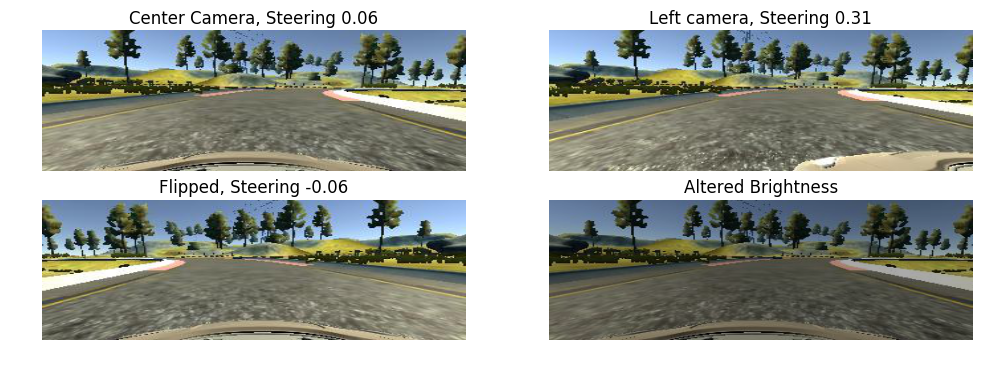

In [9]:
row = data_frame.iloc[2500]
steering = row['steering']

image = load_img(kFolderName + '/' + row["center"].strip())
image = img_to_array(image).astype(np.uint8)

left = load_img(kFolderName + '/' + row["left"].strip())
left = img_to_array(left).astype(np.uint8)

plt.subplot(2,2,1)
plt.imshow(image, aspect='auto')
plt.axis('off')
plt.title("Center Camera, Steering %.2f" % steering)

plt.subplot(2,2,2)
plt.imshow(left, aspect='auto')
plt.axis('off')
plt.title("Left camera, Steering %.2f" % (steering + kSteeringAdjustments))

plt.subplot(2,2,3)
plt.imshow(flip_image(image), aspect='auto')
plt.axis('off')
plt.title("Flipped, Steering %.2f" % (-1.0 * steering))

plt.subplot(2,2,4)
plt.imshow(alter_image_brightness(image), aspect='auto')
plt.axis('off')
plt.title("Altered Brightness")

In [10]:
kMinBrightness = 0.25
kAddedSteering = 0.002
kXRange = 80
kYRange = 40
kInputCols = 320
kInputRows = 160

def traverse_image(image):
    # Translation in x direction
    translation_x = kXRange * np.random.uniform() - kXRange / 2
    
    # Changed steering angle based on x-direction
    added_steering_angle = kAddedSteering + translation_x / kXRange * 2 * 0.2
    
    # Translation in x direction
    translation_y = kYRange * np.random.uniform() - kYRange / 2
    
    # Apply the translation using warp method from opencv
    translation_matrix = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    translated_image = cv2.warpAffine(image, translation_matrix, (kInputCols, kInputRows))
    
    return translated_image, added_steering_angle

def add_shadow(image, mask):
    top_y = kInputCols * np.random.uniform()
    top_x = 0
    botom_x = kInputRows
    botom_y = kInputCols * np.random.uniform()
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    shadow_mask = 0 * image[:,:,1]

    mesh_x = np.mgrid[0:image.shape[0], 0:image.shape[1]][0]
    mesh_y = np.mgrid[0:image.shape[0], 0:image.shape[1]][1]
    
    is_mask = ((mesh_x - top_x) * (botom_y - top_y) - (botom_x - top_x) * (mesh_y - top_y)) >= 0
    shadow_mask[is_mask] = 1

    random_brightness = kMinBrightness + np.random.uniform()
    mask_on = shadow_mask == mask
    image[:,:,2][mask_on] = image[:,:,2][mask_on] * random_brightness
            
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image


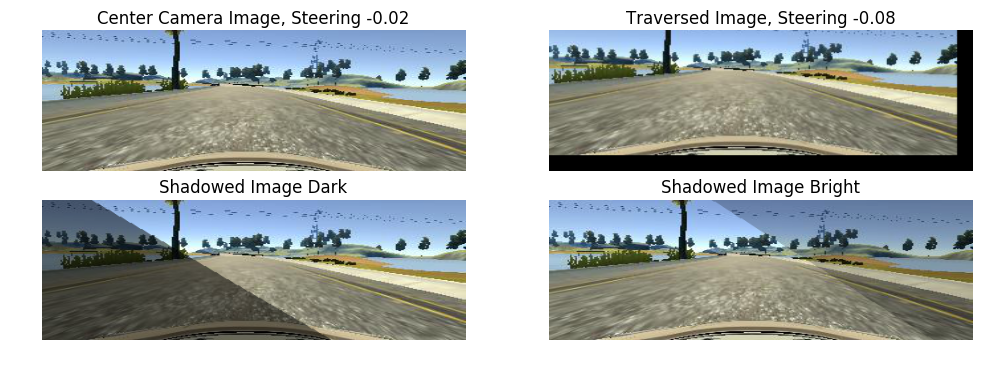

In [15]:
row = data_frame.iloc[7670]
steering = row['steering']
image = load_img(kFolderName + '/' + row["center"].strip())
image = img_to_array(image).astype(np.uint8)

plt.subplot(2,2,1)
plt.imshow(image, aspect='auto')
plt.axis('off')
plt.title("Center Camera Image, Steering %.2f" % steering)

image_traversed, steer_added = traverse_image(image)

plt.subplot(2,2,2)
plt.imshow(image_traversed, aspect='auto')
plt.axis('off')
plt.title("Traversed Image, Steering %.2f" % (steering + steer_added))

image_shadow_on = add_shadow(image, 1)
image_shadow_off = add_shadow(image, 0)

plt.subplot(2,2,3)
plt.imshow(image_shadow_on, aspect='auto')
plt.axis('off')
plt.title("Shadowed Image Dark")

plt.subplot(2,2,4)
plt.imshow(image_shadow_off, aspect='auto')
plt.axis('off')
plt.title("Shadowed Image Bright")
